## Setup

In [ ]:
import pickle
from collections import Counter
from tqdm import tqdm
import spacy
import pandas as pd
import numpy as np
import random 
import re

random.seed(10)
pd.set_option('display.max_colwidth', 1000)

In [ ]:
# Load space and disable not needed pipelines
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('ner', 'parser')

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f63be9953d0>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f63be995360>)]

In [ ]:
!pip install sentencepiece
!pip install transformers
!pip install datasets

     |████████████████████████████████| 1.2 MB 5.0 MB/s 
     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 55.7 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 68.8 MB/s 
     |████████████████████████████████| 895 kB 59.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 306 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 68.8 MB/s 
     |████████████████████████████████| 243 kB 57.9 MB/s 
     |████████████████████████████████| 133 kB 67.8 MB/s 
     |████████████████████████████████| 271 kB 77.5 MB/s 
     |████████████████████████████████| 144 kB 63.2 MB/s 
     |████████████████████████████████| 160 kB 72.4 MB/s 


### Load Data

In [ ]:
# All medium and all scie sentences plus stats after masking with noun freq 500
!gdown --id 
!gdown --id 

with open("non_sci_stats_filtered.pkl","rb") as f:
  non_sci_stats = pickle.load(f)

with open("sci_stats_filtered.pkl","rb") as f:
  sci_stats = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?id=1rJuKZVDNe6ZGRMKaIFAfOjjNft8pk2CR
To: /content/sci_stats_filtered.pkl
100% 220M/220M [00:01<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mJWJDuDp1Ugp4Hcz5g-0GM4H-OS3Fqia
To: /content/non_sci_stats_filtered.pkl
100% 28.2M/28.2M [00:00<00:00, 132MB/s] 


## Student reports

### Load data

In [ ]:
!gdown --id  
!unzip "/content/Non-scientific sentences.zip" -d "/content/non_sci_sents"

In [ ]:
!gdown --id 
with open('/content/3_all_acl_cleaned.pkl', 'rb') as handle:
    acl_cleaned = pickle.load(handle)
acl_sample = random.sample(acl_cleaned.input.to_list(), 26000)

Downloading...
From: https://drive.google.com/uc?id=17s3Zg8TqOj6DNH-e7d07uTIC3auEKSrr
To: /content/3_all_acl_cleaned.pkl
100% 31.2M/31.2M [00:00<00:00, 118MB/s] 


In [ ]:
!gdown --id 

with open('/content/bleu_cleaned_gyafc.pkl', 'rb') as handle:
    gyafc_cleaned = pickle.load(handle)

gyafc_cleaned = gyafc_cleaned.formal.to_list()

Downloading...
From: https://drive.google.com/uc?id=1Vx9qMcVSeHGzxUzg4x-G8PeN8L7w8rdd
To: /content/bleu_cleaned_gyafc.pkl
100% 3.36M/3.36M [00:00<00:00, 108MB/s]


### Clean data

In [ ]:
import os
dir_path = "/content/non_sci_sents/Non-scientific sentences"
files = os.listdir(dir_path)
student_text = []
for f in files:
  f_path = dir_path +"/"+ f
  with open(f_path) as f:
    contents = f.read().splitlines()
  student_text.extend(contents) 

In [ ]:
def filter_text(text):
  # Replace empty text
  text_filtered = [t for t in text if t != ""]
  # Replace numbers by NUM
  text_filtered = [re.sub('\d+', 'NUM', t) for t in text_filtered]
  # Remove links 
  text_filtered = [re.sub('https?:', '<unk>', t) for t in text_filtered]
  text_filtered = [re.sub('www.', '<unk>', t) for t in text_filtered]
  # lower 
  text_filtered = [t.lower() for t in text_filtered]
  return text_filtered

In [ ]:
student_filtered = filter_text(student_text)
acl_filtered = filter_text(acl_cleaned.input.to_list())
gyafc_filtered = filter_text(gyafc_cleaned)

## Analyze Data

### Lemmatize & Pos tokens

In [ ]:
data = student_filtered.copy()
data.extend(acl_filtered)
data.extend(gyafc_filtered)

In [ ]:
lemma_tokens = []
lemma_sentences = []
pos_tags = []
for text in tqdm(data):
  doc = nlp(text)
  #tokens = []
  for token in doc:
    pos_tags.append(token.pos_)
    #tokens.append(token.lemma_)
    lemma_tokens.append(token.lemma_)



100%|██████████| 174927/174927 [07:02<00:00, 414.20it/s]


In [ ]:
token_pos_zip = zip(lemma_tokens, pos_tags)

### Analyze word frequency

In [ ]:
nouns = [word for word, tag in token_pos_zip if tag == "NOUN" or tag == "PROPN"]
frequencies_nouns = Counter(noun for noun in nouns if len(noun) > 1)

In [ ]:
word_freq = frequencies_nouns.most_common(1500)

In [ ]:
word_list = [item[0] for item in word_freq]

### Apply masking

In [ ]:
# Masked sentences based on most common words
def mask_sent(sample, word_counter, num_words, bool_noun):
  word_freq = word_counter.most_common(num_words)

  # Extracting the first entry from each sublist
  word_list = [item[0] for item in word_freq]

  masked_sentences = []
  for sent in tqdm(sample):
    new_sent = []
    doc = nlp(sent)
    for token in doc:
      # True if filtering os only for nouns
      if bool_noun:
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
          if token.lemma_ in word_list:
            new_sent.append(token.text)
          else:
            new_sent.append("<unk>")
        else:
          new_sent.append(token.text.lower())

      # If filtering for all words
      else:
        
        if token.lemma_ in word_list:
          new_sent.append(token.text.lower())
        else:
          new_sent.append("<unk>")
      
    masked_sentences.append(" ".join(new_sent))
    # Create a dframe for easier comparison
  dataframe = pd.DataFrame(list(zip(sample, masked_sentences)), columns = ["original", "masked"])
  return masked_sentences, dataframe


In [ ]:
# The higher the number for most common the less masking as more words are considered
masked_sent, df_student = mask_sent(student_filtered, frequencies_nouns, 1500, True)
masked_sent, df_acl = mask_sent(acl_filtered, frequencies_nouns, 1500, True)
masked_sent, df_gyafc = mask_sent(gyafc_filtered, frequencies_nouns, 1500, True)

100%|██████████| 29115/29115 [01:03<00:00, 457.49it/s]


In [ ]:
import os 
from transformers import AutoTokenizer,AutoModel, BertForSequenceClassification
def load_model():
  if not os.path.isdir('/content/SciBERT'):
    os.mkdir("SciBERT")
    %cd SciBERT
    !gdown --id 
    !gdown --id 
    %cd ..
  tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
  model = BertForSequenceClassification.from_pretrained("/content/SciBERT",local_files_only=True)
  return model, tokenizer


In [ ]:
with open('filter_word_list_SciBERT.pkl', 'wb') as handle:
    pickle.dump(word_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sample = ["hallo this is stupod", "yeah kinda"]

tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = BertForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels = 2)

def inference(texts, word_list):
  # Masking
  sents = []
  for sent in texts:
    sents.append(" " .join([token.text if token.lemma_ in word_list else "<unk>"  if token.pos_ == "NOUN" or token.pos_ == "PROPN" else token.text.lower() for token in nlp(sent)]))

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

### Statistics about masking

In [ ]:
def get_unk_stats(df):
  sent_lens = []
  num_unkns = []

  sents = df["masked"]
  orig_sents = df["original"]
  for sent, orig_sent in tqdm(zip(sents, orig_sents)):
    num_unk = sent.count("<unk>")
    num_unkns.append(num_unk)
    doc = nlp(orig_sent)
    len_sent = len(doc)
    sent_lens.append(len_sent)
  
  sent_lens = np.array(sent_lens)
  num_unkns = np.array(num_unkns)
  print("#####")
  print(f"Mean: {np.mean(num_unkns / sent_lens)}")
  print("#####")
  df["sent_len"] = sent_lens
  df["num_unk"] = num_unkns
  df["unk_ratio"] = num_unkns / sent_lens
  return df

In [ ]:
df_student  = get_unk_stats(df_student)
df_acl  = get_unk_stats(df_acl)
df_gyafc  = get_unk_stats(df_gyafc)

### Align corpora by len and unk ratio
- Both corpora shoudl have the same mean len and mean unk ratio
- Cap both corpora by a max of unk ratio of .6
- check the num of entries in each 0.05 bin of the non sci corpus
- sample this num of entries from the 0.05 bins from the sci corpus
- Changed max sentence length to  60
! TODO: remove non character tokens from token counting 



- Sentenced fíltered to contain a minimum of 5 words

In [ ]:
def align_df_stats(df1,df2):
  # Analyse df1
  num_entries = []
  for i in np.linspace(0,.6,13):
    entries = len(df1[(df1.unk_ratio >= i) & (df1.unk_ratio < i+0.05) ])
    num_entries.append(entries)
  # Sample from df2 to have similar distribution
  train_sci_sample = pd.DataFrame()
  for i, num_entry in zip(np.linspace(0,.6,13), num_entries):
    entries = df2[(df2.unk_ratio >= i) & (df2.unk_ratio < i+0.05) ].sample(num_entry, random_state=1, replace = False)
    train_sci_sample= pd.concat([train_sci_sample, entries])
  
  return train_sci_sample
    

In [ ]:
df_student_f = df_student[(df_student.sent_len < 60) & (df_student.sent_len > 2) & (df_student.unk_ratio < 0.4)]
df_acl_f = df_acl[(df_acl.sent_len < 60) & (df_acl.sent_len > 2) & (df_acl.unk_ratio < 0.4)]
df_gyafc_f = df_gyafc[(df_gyafc.sent_len < 60) & (df_gyafc.sent_len > 2) & (df_gyafc.unk_ratio < 0.4)]

In [ ]:
df_acl_f_sample = df_acl_f.sample(25000)

In [ ]:
df_gyafc_f_sample = df_gyafc_f.sample(25000)

In [ ]:
df_gyafc_f_sample.masked = [s.replace("!","").replace(".","").replace("?","").strip() for s in df_gyafc_f_sample.masked]

In [ ]:
sci_stats = df_acl_f_sample
non_sci_stats = df_student_f
normal_sents = df_gyafc_f_sample

# Train SciBert Classifier

### Init libraries

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,AutoModel, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Used device is {device}')

Used device is cuda:0


### Setup the Dataset

Creating the different dataloaders
- First define settings for training

In [ ]:
sci_stats["label"] = 1
non_sci_stats["label"] = 0
normal_sents["label"] = 2
combined_dataset = pd.concat([sci_stats,non_sci_stats, normal_sents])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data = combined_dataset["masked"]
labels = combined_dataset["label"]

In [ ]:
# Splitting data -> adpat split if necessary
data_train, data_valtest, labels_train, labels_valtest = train_test_split(list(data), list(labels), test_size=0.05, random_state = 42) 
data_val, data_test, labels_val, labels_test = train_test_split(data_valtest, labels_valtest, test_size=0.5,random_state = 42) 

assert len(data) == len(data_test)+len(data_train)+len(data_val)

print(f'Number of training sentences: \t {len(data_train)}')
print(f'Number of validation sentences:  {len(data_val)}')
print(f'Number of test sentences: \t {len(data_test)}')

Number of training sentences: 	 70545
Number of validation sentences:  1856
Number of test sentences: 	 1857


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(list(data_train),truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = True,
                             max_length=50,
                             return_attention_mask=True,
                             return_tensors='pt')
val_encodings = tokenizer(list(data_val), truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = True,
                             max_length=50,
                             return_attention_mask=True,
                             return_tensors='pt')
test_encodings = tokenizer(list(data_test), truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = True,
                             max_length=50,
                             return_attention_mask=True,
                             return_tensors='pt')
#test_encodings = tokenizer(list(data_test), padding=True)

In [ ]:
import torch

class Dataset_style(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = Dataset_style(train_encodings, list(labels_train))
val_dataset = Dataset_style(val_encodings, list(labels_val))
test_dataset = Dataset_style(test_encodings, list(labels_test))

### Setup Trainer

In [ ]:
model = BertForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels = 3)

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
from datasets import load_metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis = -1)
  return metric.compute(predictions = predictions, references = labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=128,  # batch size per device during training
    per_device_eval_batch_size=128,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    load_best_model_at_end = True,
    evaluation_strategy = "steps",
    eval_steps = 100,
    save_strategy = "steps",
    save_steps = 100,
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics           
)

trainer.train()

***** Running training *****
  Num examples = 70545
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 2208
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Step,Training Loss,Validation Loss,Accuracy
100,0.497200,0.160715,0.947198
200,0.148000,0.118101,0.960668
300,0.130900,0.094829,0.963901
400,0.103100,0.098815,0.966056
500,0.103800,0.072841,0.969828
600,0.075200,0.094178,0.968211
700,0.051900,0.074591,0.974138
800,0.058500,0.075857,0.969828
900,0.059800,0.081615,0.971983
1000,0.058500,0.069455,0.978448


***** Running Evaluation *****
  Num examples = 1856
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 1856
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad

TrainOutput(global_step=2208, training_loss=0.06803893010584179, metrics={'train_runtime': 1419.7243, 'train_samples_per_second': 198.757, 'train_steps_per_second': 1.555, 'total_flos': 7250521895946000.0, 'train_loss': 0.06803893010584179, 'epoch': 4.0})

In [ ]:
model.eval()

In [ ]:
res = tokenizer.encode("i trained the model for 5 epochs", return_tensors="pt").to(device)

In [ ]:
from torch import nn
model(res)["logits"]

tensor([[ 1.3361,  1.5112, -3.0866]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/results/checkpoint-400", num_labels = 2)

loading configuration file /content/results/checkpoint-400/config.json
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading weights file /content/results/checkpoint-400/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceCla

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/model")

Configuration saved in /content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/model/config.json
Model weights saved in /content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/model/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/tokenizer")

tokenizer config file saved in /content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/tokenizer/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/tokenizer/special_tokens_map.json


('/content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/tokenizer/vocab.txt',
 '/content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/tokenizer/tokenizer.json')

# Style Classifier Inference

### Setup

In [ ]:
from scipy.special import softmax
from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import os

!gdown --id 
!unzip checkpoint18k.zip
model = BertForSequenceClassification.from_pretrained("/content/content/results/checkpoint-18000", num_labels = 2)
os.mkdir("results")
os.mkdir("logs")

Downloading...
From: https://drive.google.com/uc?id=1aKPM3awSVDxydKWTNg7_UVGABT2cfE0J
To: /content/checkpoint18k.zip
100% 1.10G/1.10G [00:07<00:00, 156MB/s]
Archive:  checkpoint18k.zip
   creating: content/results/checkpoint-18000/
  inflating: content/results/checkpoint-18000/rng_state.pth  
  inflating: content/results/checkpoint-18000/trainer_state.json  
  inflating: content/results/checkpoint-18000/pytorch_model.bin  
  inflating: content/results/checkpoint-18000/optimizer.pt  
 extracting: content/results/checkpoint-18000/.zip  
  inflating: content/results/checkpoint-18000/scheduler.pt  
  inflating: content/results/checkpoint-18000/config.json  
  inflating: content/results/checkpoint-18000/training_args.bin  


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1000,
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    #train_dataset=train_dataset,         # training dataset
    #eval_dataset=val_dataset             # evaluation dataset
)

In [ ]:
# predict labels and create pandas df for overview
def pred_df(data,labels, encoded_dataset = None):
  if not encoded_dataset:
    encodings = tokenizer(list(data), padding=True)
    encoded_dataset = Dataset_style(encodings, list(labels))
  pred = trainer.predict(encoded_dataset)
  res = softmax(pred[0], axis = 1)
  df = pd.DataFrame.from_records(res, columns = ["prob_non_sci", "prob_sci"])
  df["sent"] = list(data)
  df['pred_label'] = np.where((df.prob_non_sci > df.prob_sci),0,1)
  df["true_label"] = list(labels)
  df = df[["sent", "true_label", "pred_label", "prob_non_sci","prob_sci"]]
  return df

# This provides just a way to illustrate our confusion matrices in a nice and labeled way
def show_confusion_matrix(confusion_matrix, names = ['Scientific', 'Non-Scientifc'], save_path = None):
  confusion_df = pd.DataFrame(cm, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)
  if save_path:
    plt.savefig(save_path)
  plt.show()

### Inference & Analysis

#### Create a df offering an overview over the prediction results

In [ ]:
df2 = pred_df(data_test, labels_test)

***** Running Prediction *****
  Num examples = 10722
  Batch size = 64


#### Create a confusion matrix

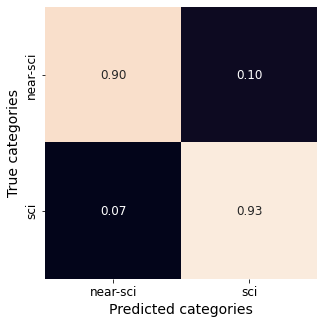

In [ ]:
cm = confusion_matrix(df2.true_label, df2.pred_label, normalize = 'true')
show_confusion_matrix(cm, names = ['near-sci', 'sci'], save_path=None)

#### Classification report

In [ ]:
report = classification_report(df2.true_label, df2.pred_label, output_dict=True)
report_df = pd.DataFrame(report).transpose()


report_df

,precision,recall,f1-score,support
0,0.929120,0.901248,0.914972,5367.000000
1,0.903916,0.931092,0.917303,5355.000000
accuracy,0.916154,0.916154,0.916154,0.916154
macro avg,0.916518,0.916170,0.916138,10722.000000
weighted avg,0.916532,0.916154,0.916136,10722.000000


# T-SNE clustering

### Init methods for T-SNE

In [ ]:
from transformers import BertModel
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Data Structure
class SentenceDataset(Dataset):
    def __init__(self, sents, labels, tokenizer):
        self.sents = sents
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.sents)
    
    def __getitem__(self, item):
        
        sent = str(self.sents[item])
        label = self.labels[item]

        encoding = tokenizer(sent,
                             truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = "max_length",
                             max_length=60,
                             return_attention_mask=True,
                             return_tensors='pt')
      
        return { 'sent': sent, 'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
        }
# Data Loader
def create_data_loader(sentences, labels, tokenizer, batch_size):
    ds = SentenceDataset(
        sents=sentences, #.to_numpy()
        labels=labels, #.to_numpy()
        tokenizer=tokenizer,
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=3
    )

def get_cluster_vectors(data_loader, model):
  # put to eval mode to disable dropout 
  model = model.eval()
  model.to(device)

  with torch.no_grad():
    CLS_vectors = []
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask) #dim BATCH_SIZE x 3
      CLS_vectors.extend(outputs["pooler_output"])
  CLS_vectors = torch.stack(CLS_vectors).cpu().numpy()
  return CLS_vectors

def plot_clusters(vectors, labels, names = {1: 'Sci:', 0: 'NonSci'}, title = 't-SNE of CLS-vectors'):

  #Plotting
  dim = vectors.shape[1]
  labels_unique = list(set(labels))
  n_classes = len(labels_unique)
  assert n_classes == len(names)

  fig, ax = plt.subplots(1,1, figsize = (16, 5))
  for i, label in enumerate(labels_unique):
    x = vectors[labels == label,0]
    y = vectors[labels == label,1]
    ax.scatter(x,y, label = names[i] ,alpha=.8, edgecolors='none')


  ax.set_title(title, fontsize = 12)
  ax.legend()
  plt.grid()
  plt.show()


def illustrate_cluster(dataframe, classifier, n_components = 2, names = {1: 'Sci:', 0: 'NonSci'}, title = 't-SNE of CLS-vectors'):

  # put data into correct form 
  data_loader = create_data_loader(dataframe['sent'], dataframe['true_label'], tokenizer, 12)

  # get CLS emebddings
  print('Calculating CLS embeddings!')
  CLS_vectors = get_cluster_vectors(data_loader = data_loader, model = classifier)

  # Data dimesnionality reduction
  print('Reducing data dimesionality for illustration. This might take a while!')
  tsne = TSNE(n_components = n_components , init='pca', random_state=42)
  CLS_vectors_fitted = tsne.fit_transform(CLS_vectors)

  plot_clusters(vectors = CLS_vectors_fitted, labels = dataframe['true_label'], names = names, title = title)

  return CLS_vectors_fitted


def dislpay_sents_cluster(xmin, xmax, ymin, ymax, CLS_vecs, all_sents, labels, n_sents = 10):
  idxs = list(range(CLS_vecs.shape[0]))
  filtered_idxs = []
  for idx in idxs:
    x = CLS_vecs[idx,0]
    y = CLS_vecs[idx,1]
    if xmin<= x and x <= xmax:
      if ymin <= y and y<=ymax:
        filtered_idxs.append(idx)

  chosen_idxs = random.sample(filtered_idxs, n_sents)
  for idx in chosen_idxs:
    print(all_sents[idx], '\t |', labels[idx].item() , '\n')

### Run T-SNE clustering 




#### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_student["label"] = 0
df_acl["label"] = 1
df_gyafc["label"] = 2

In [ ]:
sample_gyafc = df_gyafc.sample(7000)
sample_acl = df_acl.sample(7000)
sample_student = df_student.sample(7000)

In [ ]:
all_samples = pd.concat([sample_acl, sample_gyafc, sample_student])
all_samples = all_samples.rename(columns={"original": "drop", "masked": "sent", "label": "true_label"})
all_samples = all_samples.drop(["drop"], axis=1)
all_samples = all_samples.reset_index(drop=True)

#### Run tsna

In [ ]:
model2 = BertModel.from_pretrained("/content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/model", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

Some weights of the model checkpoint at /content/drive/MyDrive/Style_Classifier_MRP2/SciBERT_student_acl/model were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Calculating CLS embeddings!


100%|██████████| 1750/1750 [01:11<00:00, 24.45it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Reducing data dimesionality for illustration. This might take a while!


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


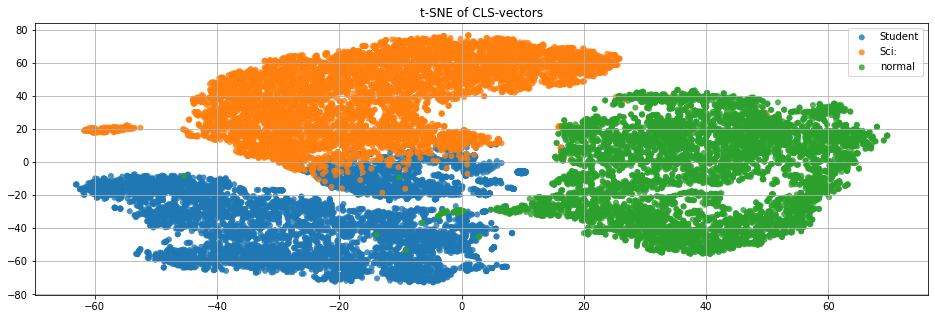

In [ ]:
#input_df = pd.DataFrame(list(zip(data_test, labels_test)), columns = ["sent", "true_label"])
input_df = all_samples
cls_vecs = illustrate_cluster(dataframe = input_df, classifier = model2, n_components = 2, names = {1: 'Sci:', 0: 'Student', 2:"normal"}, title = 't-SNE of CLS-vectors')

In [ ]:
input_df = pd.DataFrame(list(zip(data_train, labels_train)), columns = ["sent", "true_label"])
cls_vecs = illustrate_cluster(dataframe = input_df, classifier = model2, n_components = 2, names = {1: 'Sci:', 0: 'Medium'}, title = 't-SNE of CLS-vectors')

In [ ]:
dislpay_sents_cluster(xmin = -20, 
                      xmax=-5, 
                      ymin = -20, 
                      ymax=-10, 
                      CLS_vecs=cls_vecs, all_sents=input_df['sent'], labels=input_df['true_label'], n_sents = 1000)